In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [69]:
# Dominio de -1 a 1 en 64 datos debibo a los 6 genes
# 000 000, 000 001, ... , 111 111
x = np.linspace(-1, 1, 64)
y = x**2

print(x)
print(y)

[-1.         -0.96825397 -0.93650794 -0.9047619  -0.87301587 -0.84126984
 -0.80952381 -0.77777778 -0.74603175 -0.71428571 -0.68253968 -0.65079365
 -0.61904762 -0.58730159 -0.55555556 -0.52380952 -0.49206349 -0.46031746
 -0.42857143 -0.3968254  -0.36507937 -0.33333333 -0.3015873  -0.26984127
 -0.23809524 -0.20634921 -0.17460317 -0.14285714 -0.11111111 -0.07936508
 -0.04761905 -0.01587302  0.01587302  0.04761905  0.07936508  0.11111111
  0.14285714  0.17460317  0.20634921  0.23809524  0.26984127  0.3015873
  0.33333333  0.36507937  0.3968254   0.42857143  0.46031746  0.49206349
  0.52380952  0.55555556  0.58730159  0.61904762  0.65079365  0.68253968
  0.71428571  0.74603175  0.77777778  0.80952381  0.84126984  0.87301587
  0.9047619   0.93650794  0.96825397  1.        ]
[1.00000000e+00 9.37515747e-01 8.77047115e-01 8.18594104e-01
 7.62156715e-01 7.07734946e-01 6.55328798e-01 6.04938272e-01
 5.56563366e-01 5.10204082e-01 4.65860418e-01 4.23532376e-01
 3.83219955e-01 3.44923154e-01 3.08641

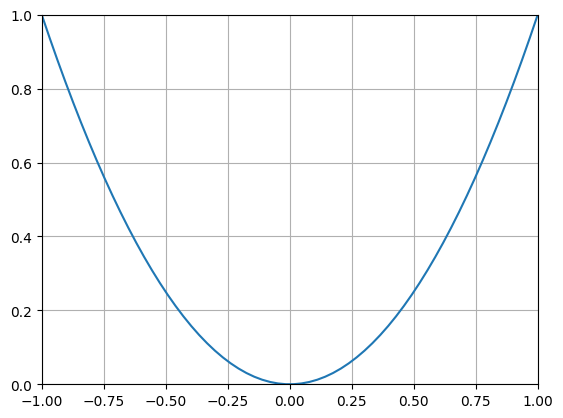

In [3]:
plt.plot(x, y)
plt.axis([-1, 1, 0, 1])
plt.grid(True)
plt.show()

No es necesario tener toda la poblacion generada, habra casos donde no se pueda generar todos y solo necesitamos 10 individuos para empezar la cruza, el objetivo es justamente con una poblacion pequeña alcanzar lo optimo.

# Generar Poblacion

In [175]:
step = 64
valores = np.linspace(-1, 1, step)  # 64 valores entre -1 y 1

def bin2val(binario, valores):
    idx = int(binario, 2)
    return valores[idx]

def generar_individuo():
    # Índice entre 0 y 63
    idx = random.randint(0, step-1)
    # Decimal a Binario
    binario = format(idx, '06b')
    valor = bin2val(binario, valores)
    return binario, valor

# Generar padres
padres = []
val = []
for _ in range(10):
    b, v = generar_individuo()
    padres.append(b)
    val.append(v)
    print(f"{b} -> {v}")


100010 -> 0.0793650793650793
110101 -> 0.6825396825396823
011001 -> -0.2063492063492064
110110 -> 0.7142857142857142
111100 -> 0.9047619047619047
011101 -> -0.07936507936507942
010010 -> -0.4285714285714286
100100 -> 0.1428571428571428
010100 -> -0.3650793650793651
101110 -> 0.46031746031746024


Creamos nuestra poblacion inicial junto con su aptitud

In [176]:
df = pd.DataFrame({
    'Bin': padres,
    'Valor': val
})
df['fitness'] = df['Valor']**2

In [177]:
display(df)

,Bin,Valor,fitness
0,100010,0.079365,0.006299
1,110101,0.682540,0.465860
2,011001,-0.206349,0.042580
3,110110,0.714286,0.510204
4,111100,0.904762,0.818594
5,011101,-0.079365,0.006299
6,010010,-0.428571,0.183673
7,100100,0.142857,0.020408
8,010100,-0.365079,0.133283
9,101110,0.460317,0.211892


Ordenar segun su aptitud

In [178]:
df.sort_values(by='fitness', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)
#df.to_csv('poblacion_inicial.csv', index=False) # Guardar para replicar despues
display(df)

,Bin,Valor,fitness
0,111100,0.904762,0.818594
1,110110,0.714286,0.510204
2,110101,0.682540,0.465860
3,101110,0.460317,0.211892
4,010010,-0.428571,0.183673
5,010100,-0.365079,0.133283
6,011001,-0.206349,0.042580
7,100100,0.142857,0.020408
8,011101,-0.079365,0.006299
9,100010,0.079365,0.006299


Llevaremos un registro de las generaciones para lo cual tomaremos dos valores representativos de cada generacion, siendo estos el mejor valor de aptitud asi como el promedio de la generacion.  
Partiendo de los padres inicales esta sera nuestra Generacion 0.

In [179]:
df_hist = pd.DataFrame(columns=["Bin","Valor","fitness", "Avg_Fitness"])

def add_hist (df, df_hist):
    nuevo_registro = df.iloc[[0]].copy()
    nuevo_registro["Avg_Fitness"] = df["fitness"].mean()
    df_hist = pd.concat([df_hist, nuevo_registro], ignore_index=True)
    return df_hist

In [180]:
df_hist = add_hist(df, df_hist)
print(df_hist)

      Bin     Valor   fitness  Avg_Fitness
0  111100  0.904762  0.818594     0.239909


C:\Users\death\AppData\Local\Temp\ipykernel_23528\3672471164.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_hist = pd.concat([df_hist, nuevo_registro], ignore_index=True)


# Seleccion

Con nuestros 10 padres creados procedemos a la cruza  
Para esto haremos 5 parejas y cada una tendra 2 hijos


## Metodos de selección

Separaremos los padres en dos grupos segun su aptitud y usaremos dos metodos de selección, Rank y Torneo

Como proponemos 5 parejas y debido a sus aptitudes haremos 2 parejas con rank (Las que tienen mejor aptitud) y 3 por torneo(Con peor aptitud esperando que mejoren)

In [181]:
# Rank
df1 = df.iloc[:4]

# torneo
df2 = df.iloc[4:10]

In [182]:
display(df1)
display(df2)

,Bin,Valor,fitness
0,111100,0.904762,0.818594
1,110110,0.714286,0.510204
2,110101,0.682540,0.465860
3,101110,0.460317,0.211892


,Bin,Valor,fitness
4,010010,-0.428571,0.183673
5,010100,-0.365079,0.133283
6,011001,-0.206349,0.042580
7,100100,0.142857,0.020408
8,011101,-0.079365,0.006299
9,100010,0.079365,0.006299


### Rank
Formaremos parejas segun su rango de aptitud tomando asi:  
(1 - 2), (3 - 4), (5 - 6)

In [183]:
df_rs = df1.reset_index(drop=True) # Reiniciar índice para hacer nuestra cruza
display(df_rs)

,Bin,Valor,fitness
0,111100,0.904762,0.818594
1,110110,0.714286,0.510204
2,110101,0.682540,0.465860
3,101110,0.460317,0.211892


In [184]:
def parejas_rank(df):
    df_rs = df.reset_index(drop=True)
    parejas = []
    for i in range(0, len(df_rs)-1, 2):
        if i+1 < len(df_rs):
            pareja = (df_rs.iloc[i], df_rs.iloc[i+1])
            parejas.append(pareja)
    return parejas

def cruza_corte(parejas, corte_n):
    hijos = []
    for p1, p2 in parejas:
        bin1 = p1['Bin']
        bin2 = p2['Bin']
        hijo1_bin = bin1[:corte_n] + bin2[corte_n:]
        hijo2_bin = bin2[:corte_n] + bin1[corte_n:]
        hijos.append(hijo1_bin)
        hijos.append(hijo2_bin)
    return hijos


In [185]:
parejas = parejas_rank(df1)
hijos_binarios = cruza_corte(parejas, 3)

for idx, (p1, p2) in enumerate(parejas):
    print(f"Pareja {idx+1}:")
    print("Padre 1 Bin:", p1['Bin'])
    print("Padre 2 Bin:", p2['Bin'])
    print("---")

for idx, hijo_bin in enumerate(hijos_binarios):
    print(f"Hijo {idx+1} Bin:", hijo_bin)

Pareja 1:
Padre 1 Bin: 111100
Padre 2 Bin: 110110
---
Pareja 2:
Padre 1 Bin: 110101
Padre 2 Bin: 101110
---
Hijo 1 Bin: 111110
Hijo 2 Bin: 110100
Hijo 3 Bin: 110110
Hijo 4 Bin: 101101


In [186]:
gen1 = pd.DataFrame(hijos_binarios, columns=['Bin'])
gen1['Valor'] = gen1['Bin'].apply(lambda b: bin2val(b, valores))
gen1['fitness'] = gen1['Valor']**2

gen1_r = pd.concat([df_rs, gen1], ignore_index=True)

In [187]:
gen1_r.sort_values(by='fitness', ascending=False, inplace=True)
display(gen1_r)

,Bin,Valor,fitness
4,111110,0.968254,0.937516
0,111100,0.904762,0.818594
6,110110,0.714286,0.510204
1,110110,0.714286,0.510204
2,110101,0.682540,0.465860
5,110100,0.650794,0.423532
3,101110,0.460317,0.211892
7,101101,0.428571,0.183673


### Torneo

En una lista de n elementos formaremos parejas la siguiente manera:  
(1 - n), (2 - n-1), (3 - n-2) y asi sucesivamente

In [188]:
df_ts = df2.reset_index(drop=True)
display(df_ts)

,Bin,Valor,fitness
0,010010,-0.428571,0.183673
1,010100,-0.365079,0.133283
2,011001,-0.206349,0.042580
3,100100,0.142857,0.020408
4,011101,-0.079365,0.006299
5,100010,0.079365,0.006299


In [189]:
def parejas_tournament(df):
    df_rs = df.reset_index(drop=True)
    parejas = []
    n = len(df_rs)
    for i in range(n // 2):
        pareja = (df_rs.iloc[i], df_rs.iloc[n - 1 - i])
        parejas.append(pareja)
    return parejas

parejas = parejas_tournament(df2)
hijos_binarios = cruza_corte(parejas, 3)
for idx, (p1, p2) in enumerate(parejas):
    print(f"Pareja {idx+1}:")
    print("Padre 1 Bin:", p1['Bin'])
    print("Padre 2 Bin:", p2['Bin'])
    print("---")

for idx, hijo_bin in enumerate(hijos_binarios):
    print(f"Hijo {idx+1} Bin:", hijo_bin)

Pareja 1:
Padre 1 Bin: 010010
Padre 2 Bin: 100010
---
Pareja 2:
Padre 1 Bin: 010100
Padre 2 Bin: 011101
---
Pareja 3:
Padre 1 Bin: 011001
Padre 2 Bin: 100100
---
Hijo 1 Bin: 010010
Hijo 2 Bin: 100010
Hijo 3 Bin: 010101
Hijo 4 Bin: 011100
Hijo 5 Bin: 011100
Hijo 6 Bin: 100001


In [190]:
gen1_t = pd.DataFrame(hijos_binarios, columns=['Bin'])
gen1_t['Valor'] = gen1_t['Bin'].apply(lambda b: bin2val(b, valores))
gen1_t['fitness'] = gen1_t['Valor']**2

gen1_t = pd.concat([df_ts, gen1_t], ignore_index=True)
display(gen1_t)

,Bin,Valor,fitness
0,010010,-0.428571,0.183673
1,010100,-0.365079,0.133283
2,011001,-0.206349,0.042580
3,100100,0.142857,0.020408
4,011101,-0.079365,0.006299
5,100010,0.079365,0.006299
6,010010,-0.428571,0.183673
7,100010,0.079365,0.006299
8,010101,-0.333333,0.111111
9,011100,-0.111111,0.012346


Una vez que hemos hecho nuestras dos cruzas uniremos toda nuestra poblacion y obtenemos nuestros datos de control

In [191]:
gen1 = pd.concat([gen1_r, gen1_t], ignore_index=True)
gen1.sort_values(by='fitness', ascending=False, inplace=True)
gen1.reset_index(drop=True, inplace=True)
display(gen1)

,Bin,Valor,fitness
0,111110,0.968254,0.937516
1,111100,0.904762,0.818594
2,110110,0.714286,0.510204
3,110110,0.714286,0.510204
4,110101,0.682540,0.465860
5,110100,0.650794,0.423532
6,101110,0.460317,0.211892
7,010010,-0.428571,0.183673
8,010010,-0.428571,0.183673
9,101101,0.428571,0.183673


De estos tomaremos solo los 10 más aptos que pasaran a la siguiente generacion.

In [192]:
gen1 = gen1.iloc[:10]
print(gen1)

      Bin     Valor   fitness
0  111110  0.968254  0.937516
1  111100  0.904762  0.818594
2  110110  0.714286  0.510204
3  110110  0.714286  0.510204
4  110101  0.682540  0.465860
5  110100  0.650794  0.423532
6  101110  0.460317  0.211892
7  010010 -0.428571  0.183673
8  010010 -0.428571  0.183673
9  101101  0.428571  0.183673


In [193]:
df_hist = add_hist(gen1, df_hist)

Esto marca el final de nuestra primera generacion ya que se hizo la cruza y nos quedamos con los 10 mayormente aptos, con lo hecho anteriormente ahora solo queda repetir el proceso hasta completar el criterio de paro.

# Ciclo

En este caso nuestro criterio de paro sera por numero de generaciones, es decir manualmente asignaremos cuantas generaciones queremos que corran antes de detenernos

In [194]:
for i in range(5): # Repetir el proceso de selección, cruza y reemplazo
    # Rank
    df1 = gen1.iloc[:4]
    # torneo
    df2 = gen1.iloc[4:10]


    # Cruza por rank
    parejas = parejas_rank(df1)
    hijos_binarios = cruza_corte(parejas, 3)
    gen1_r = pd.DataFrame(hijos_binarios, columns=['Bin'])
    gen1_r['Valor'] = gen1_r['Bin'].apply(lambda b: bin2val(b, valores))
    gen1_r['fitness'] = gen1_r['Valor']**2
    gen1_r = pd.concat([df1.reset_index(drop=True), gen1_r], ignore_index=True)

    # Cruza por torneo
    parejas = parejas_tournament(df2)
    hijos_binarios = cruza_corte(parejas, 3)
    gen1_t = pd.DataFrame(hijos_binarios, columns=['Bin'])
    gen1_t['Valor'] = gen1_t['Bin'].apply(lambda b: bin2val(b, valores))
    gen1_t['fitness'] = gen1_t['Valor']**2
    gen1_t = pd.concat([df2.reset_index(drop=True), gen1_t], ignore_index=True)


    # Unir y seleccionar los mejores 10
    gen1 = pd.concat([gen1_r, gen1_t], ignore_index=True)
    gen1.sort_values(by='fitness', ascending=False, inplace=True)
    gen1.reset_index(drop=True, inplace=True)
    gen1 = gen1.iloc[:10]
    
    # Registrar estadísticas
    df_hist = add_hist(gen1, df_hist)

In [195]:
print(gen1)

      Bin     Valor   fitness
0  111110  0.968254  0.937516
1  111110  0.968254  0.937516
2  111110  0.968254  0.937516
3  111110  0.968254  0.937516
4  111110  0.968254  0.937516
5  111110  0.968254  0.937516
6  111110  0.968254  0.937516
7  111110  0.968254  0.937516
8  111110  0.968254  0.937516
9  111110  0.968254  0.937516


In [196]:
print(df_hist)

      Bin     Valor   fitness  Avg_Fitness
0  111100  0.904762  0.818594     0.239909
1  111110  0.968254  0.937516     0.442882
2  111110  0.968254  0.937516     0.648476
3  111110  0.968254  0.937516     0.804485
4  111110  0.968254  0.937516     0.937516
5  111110  0.968254  0.937516     0.937516
6  111110  0.968254  0.937516     0.937516


# Analisando Nuestro Algoritmo

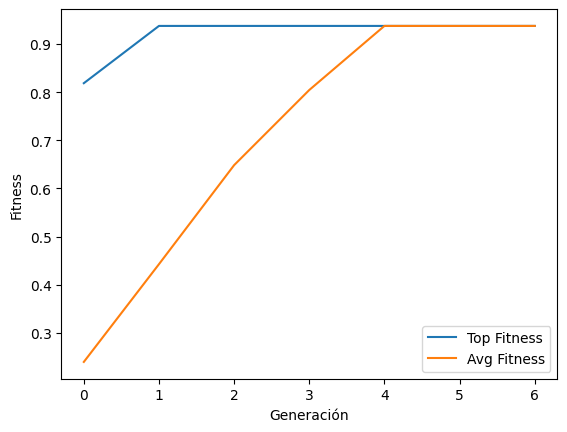

In [197]:
plt.plot(df_hist['fitness'], label='Top Fitness')
plt.plot(df_hist['Avg_Fitness'], label='Avg Fitness')
plt.xlabel('Generación')
plt.ylabel('Fitness')
plt.legend()
plt.show()

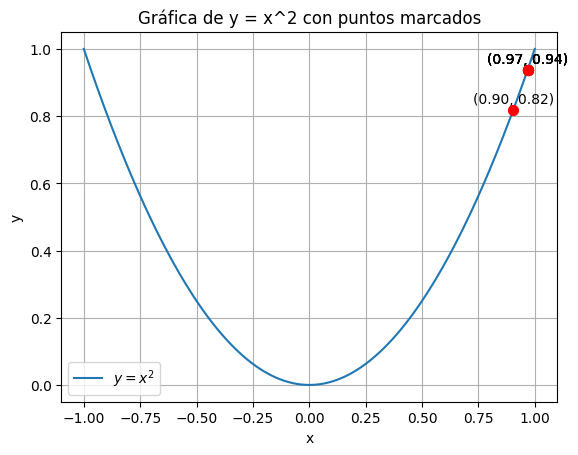

In [198]:
# Rango de x
x = np.linspace(-1, 1, 200)
y = x**2

pts_top_fitness = df_hist.loc[0:5, ['Valor', 'fitness']].to_numpy()
#pts_avg_fitness = df_hist.loc[[0, 0], ['Valor', 'Avg_Fitness']].to_numpy()

# Graficar la función
plt.plot(x, y, label='$y = x^2$')

# Marcar los puntos
for px, py in pts_top_fitness:
    plt.scatter(px, py, color='red', s=50, zorder=5)  # punto
    plt.text(px, py + 0.02, f"({px:.2f}, {py:.2f})", ha='center')  # etiqueta

#for px, py in pts_avg_fitness:
#    plt.scatter(px, py, color='red', s=50, zorder=5)  # punto
#    plt.text(px, py + 0.02, f"({px:.2f}, {py:.2f})", ha='center')  # etiqueta

plt.xlabel("x")
plt.ylabel("y")
plt.title("Gráfica de y = x^2 con puntos marcados")
plt.legend()
plt.grid(True)
plt.show()